In [97]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [98]:
import numpy as np
import pandas as pd

In [99]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [100]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [101]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [102]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [103]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [104]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [105]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [106]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [107]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [108]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

In [111]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)

In [112]:
# Sort the dataframe by date
precip_df.set_index('date').head()

precip_df.rename(columns={'prcp' : 'Precipitation'}).head()

,date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


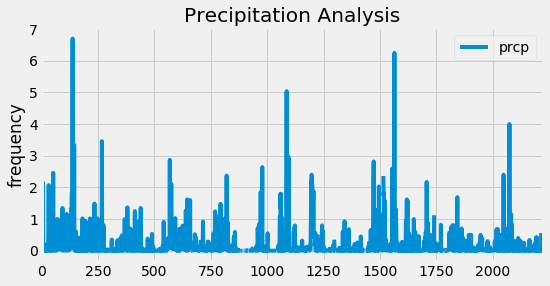

In [113]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = percep_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis")
ax.set_ylabel('frequency')
plt.show()

In [114]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [115]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {locations} available locations")

There are 9 available locations


In [117]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
m_active_station = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
m_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [118]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for most active station?

most_active_station= session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
most_active_station

[(54.0, 85.0, 71.66378066378067)]

In [119]:
# Choose the station with the highest number of temperature observations.

most_station_name = session.query(Station.name).filter(Station.station == active[0][0]).all() 

print(most_station_name)

[('WAIHEE 837.5, HI US',)]


In [120]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_observation = session.query(Measurement.tobs).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
temperature_observation_df = pd.DataFrame(temperature_observation)
legend = ['tobs']

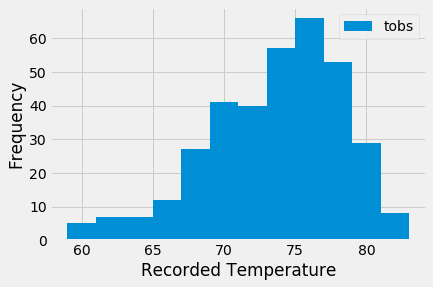

In [121]:
# Plot the results as a histogram

plt.hist(temperature_observation_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

In [122]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [123]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2012, 2, 28)
trip_leave = dt.date(2012, 3, 5)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(61.0, 70.08928571428571, 75.0)]


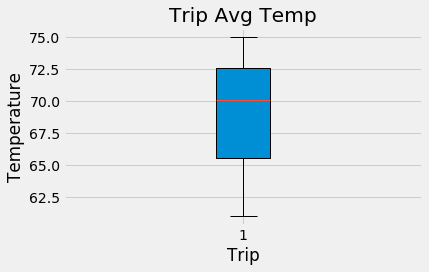

In [124]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
x = range(len(temp_avg_lst_year))
ax.boxplot(temp_avg_lst_year, patch_artist=True)
ax.set_title("Trip Avg Temp")
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

In [125]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall = session.query(Measurement.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).\
filter(Measurement.date >= '2016-01-06').filter(Measurement.date <= '2016-01-14').\
order_by(func.sum(Measurement.prcp).desc()).group_by(Measurement.station).all()
total_rainfall_df = pd.DataFrame(total_rainfall, columns=["Station", "Precipitation Amount", "Lat", "Lng", "Elevation"])
total_rainfall_df

,Station,Precipitation Amount,Lat,Lng,Elevation
0,USC00516128,25.29,21.2716,-157.8168,3.0
1,USC00519281,7.02,21.2716,-157.8168,3.0
2,USC00514830,3.51,21.2716,-157.8168,3.0
3,USC00513117,3.51,21.2716,-157.8168,3.0
4,USC00519397,2.07,21.2716,-157.8168,3.0
5,USC00519523,0.00,21.2716,-157.8168,3.0


## Optional Challenge Assignment

In [126]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]